In [1]:
pip install transformers


     |████████████████████████████████| 2.6 MB 10.9 MB/s 
     |████████████████████████████████| 3.3 MB 50.1 MB/s 
     |████████████████████████████████| 895 kB 48.0 MB/s 
     |████████████████████████████████| 636 kB 53.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import re
import string

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import precision_score, recall_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_auc_score

#from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional,Dropout,GRU,Activation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences




In [3]:
df=pd.read_csv(r'twitter.csv')

In [4]:
df.head()

,Unnamed: 0,text,target
0,0,drasko said impressed girls cooked half chicke...,1
1,1,drasko cook half bird idiot mkr,1
2,2,hopefully cooks drasko ep mkr,1
3,3,course born serbia fucked serbian film mkr,1
4,4,girls equivalent irritating asian girls couple...,1


In [5]:
df.shape

(35787, 3)

In [6]:
df.drop(columns='Unnamed: 0',inplace=True)

In [7]:
df.head()

,text,target
0,drasko said impressed girls cooked half chicke...,1
1,drasko cook half bird idiot mkr,1
2,hopefully cooks drasko ep mkr,1
3,course born serbia fucked serbian film mkr,1
4,girls equivalent irritating asian girls couple...,1


In [8]:
# class 0 - not hate speech
# class 1 - hate speech

# Crreate class description for each row in data
df['class_descr'] = df['target'].map(lambda x: 'hate_speech' if x==1 else 'not_hate_speech')

In [9]:
# Drop NaN values in text column

df.dropna(subset=['text'], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35753 entries, 0 to 35786
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         35753 non-null  object
 1   target       35753 non-null  int64 
 2   class_descr  35753 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


# Visualize Amount of  tweets classes

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


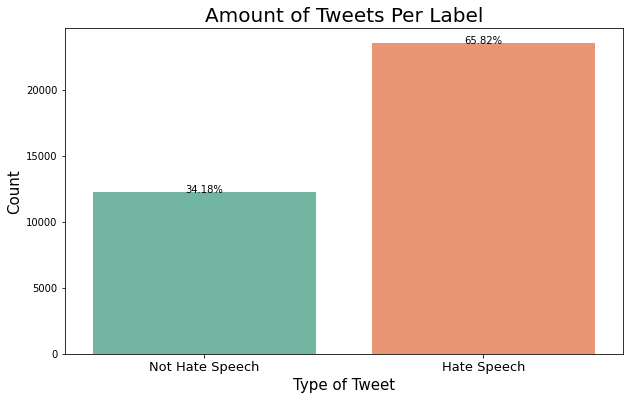

In [11]:

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(df['target'], palette='Set2')

ax.set_title('Amount of Tweets Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Not Hate Speech','Hate Speech'],fontsize = 13)

total = float(len(df)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 

In [12]:
# Create function with text cleaning techniques usinx regex

def clean_text_step1(text):
    '''
    Looking for speciffic patterns in the text and 
    removing them or replacing with space
    Function returns string
    '''
        
    # make text lowercase
    text = text.lower()
    
    # string punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    # removing patterns and replace it with nothing
    text = re.sub('\[.*?\]', '', text)
 
    # removing digits if they surounded with text or digit
    text = re.sub('\w*\d\w*', '', text)
    
    # make just 1 space if there is more then 1
    text = re.sub('\s+', ' ', text)
    
    # replace new line symbol with space
    text = re.sub('\n', ' ', text)
    
    # removing any quotes
    text = re.sub('\"+', '', text)
    
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    
    # cleaning from user name
    text = re.sub('(@[^\s]+)', '', text)
    
    # looking for # and replacing it
    text = re.sub('(#[^\s]+)', '', text)
    
    # removing `rt`
    text = re.sub('(rt)', '', text)

    # looking for `httptco`
    text = re.sub('(httptco)', '', text)
    
    # looking for `mkr`
    text = re.sub('(mkr)', '', text)
    
    text = re.sub('(sexist)', '', text)
    
    text = re.sub('(like)', '', text)
    
    text = re.sub('(women)', '', text)

    return text

In [13]:
# applying function for cleaning text data

df['text'] = df['text'].apply(clean_text_step1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35753 entries, 0 to 35786
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         35753 non-null  object
 1   target       35753 non-null  int64 
 2   class_descr  35753 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [15]:
df1=df

In [16]:
df1.drop(columns='class_descr',inplace=True)

In [17]:
df1.head()

,text,target
0,drasko said impressed girls cooked half chicke...,1
1,drasko cook half bird idiot,1
2,hopefully cooks drasko ep,1
3,course born serbia fucked serbian film,1
4,girls equivalent irritating asian girls couple...,1


In [18]:
tokenizer = Tokenizer(num_words=1500, split=' ')

tokenizer.fit_on_texts(df1['text'].values)

X = tokenizer.texts_to_sequences(df1['text'])

X = pad_sequences(X)

In [19]:
y=df1['target']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)

# LogisticRegression

In [21]:
logreg=LogisticRegression(random_state = 32)

In [22]:
logreg.fit(X_train,y_train)
logreg_predictions=logreg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


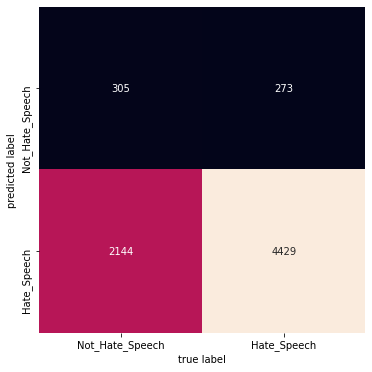

In [23]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test, logreg_predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [24]:
TP = mat[1,1] # true positive 
TN = mat[0,0] # true negatives
FP = mat[0,1] # false positives
FN = mat[1,0] # false negatives

In [25]:
Specificity = TN/(TN+FP)
Sensitivity = TP/(TP+FN)
TPR=TP/(TP+FN)
FPR=FP/(FP+TN)
roc_auc_score1=roc_auc_score(y_test, logreg_predictions)

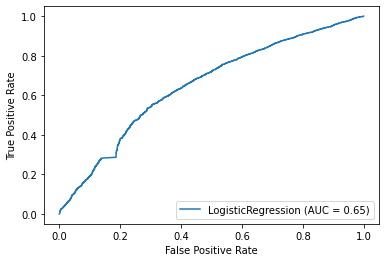

In [26]:
metrics.plot_roc_curve(logreg, X_test, y_test)
plt.show()

In [27]:
precision = precision_score(y_test, logreg_predictions)
recall = recall_score(y_test, logreg_predictions)
acc_score = accuracy_score(y_test, logreg_predictions)
score = f1_score(y_test, logreg_predictions)
print('Logistic Regression')

print('Precision: {:.4}'.format(precision))
print('Recall: {:.4}'.format(recall))

print("Accuracy: {:.4}".format(acc_score))
print("F1 Score: {:.4}".format(score))
print("Sensitivity: {:.4}".format(Sensitivity))
print("Specificity: {:.4}".format(Specificity))
print("TPR: {:.4}".format(TPR))
print("FPR: {:.4}".format(FPR))
print("roc_auc_score: {:.4}".format(roc_auc_score1))

Logistic Regression
Precision: 0.6738
Recall: 0.9419
Accuracy: 0.662
F1 Score: 0.7856
Sensitivity: 0.9419
Specificity: 0.1245
TPR: 0.9419
FPR: 0.8755
roc_auc_score: 0.5332


# Naive Bayes

In [28]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
nb_predictions = nb.predict(X_test)

In [29]:
nb_predictions

array([0, 0, 0, ..., 0, 0, 0])

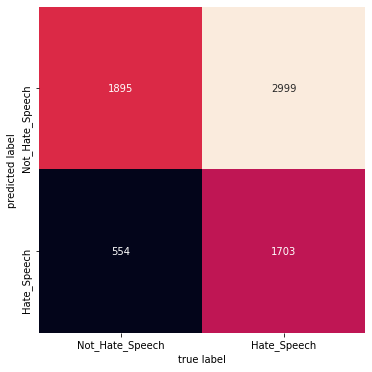

In [30]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test, nb_predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [31]:
TP = mat[1,1] # true positive 
TN = mat[0,0] # true negatives
FP = mat[0,1] # false positives
FN = mat[1,0] # false negatives

In [32]:
Specificity = TN/(TN+FP)
Sensitivity = TP/(TP+FN)
TPR=TP/(TP+FN)
FPR=FP/(FP+TN)
roc_auc_score2=roc_auc_score(y_test, nb_predictions)

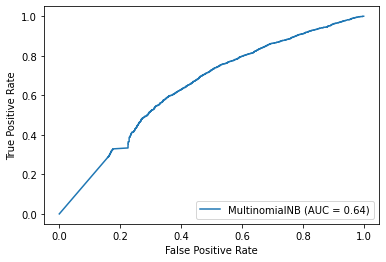

In [33]:
metrics.plot_roc_curve(nb, X_test, y_test)
plt.show()

In [34]:
precision = precision_score(y_test, nb_predictions)
recall = recall_score(y_test, nb_predictions)
acc_score = accuracy_score(y_test, nb_predictions)
score = f1_score(y_test, nb_predictions)
print('Naive Bayes')

print('Precision: {:.4}'.format(precision))
print('Recall: {:.4}'.format(recall))

print("Accuracy: {:.4}".format(acc_score))
print("F1 Score: {:.4}".format(score))
print("Sensitivity: {:.4}".format(Sensitivity))
print("Specificity: {:.4}".format(Specificity))
print("TPR: {:.4}".format(TPR))
print("FPR: {:.4}".format(FPR))
print("roc_auc_score: {:.4}".format(roc_auc_score2))

Naive Bayes
Precision: 0.7545
Recall: 0.3622
Accuracy: 0.5031
F1 Score: 0.4894
Sensitivity: 0.3622
Specificity: 0.7738
TPR: 0.3622
FPR: 0.2262
roc_auc_score: 0.568


# Random Forest Classifier

In [35]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train,y_train)
rf_predictions = rf_classifier.predict(X_test)

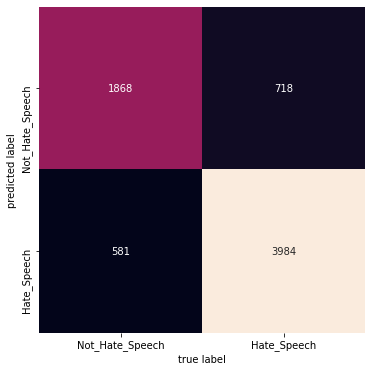

In [36]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test, rf_predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [37]:
TP = mat[1,1] # true positive 
TN = mat[0,0] # true negatives
FP = mat[0,1] # false positives
FN = mat[1,0] # false negatives

In [38]:
Specificity = TN/(TN+FP)
Sensitivity = TP/(TP+FN)
TPR=TP/(TP+FN)
FPR=FP/(FP+TN)
roc_auc_score3=roc_auc_score(y_test, rf_predictions)

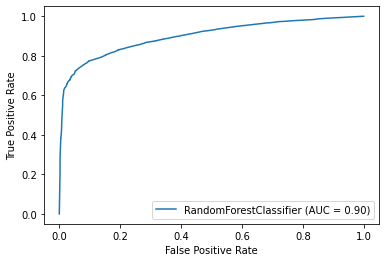

In [39]:
metrics.plot_roc_curve(rf_classifier, X_test, y_test)
plt.show()

In [40]:
precision = precision_score(y_test, rf_predictions)
recall = recall_score(y_test, rf_predictions)
acc_score = accuracy_score(y_test, rf_predictions)
score = f1_score(y_test, rf_predictions)
print('Random Forest Classifier')

print('Precision: {:.4}'.format(precision))
print('Recall: {:.4}'.format(recall))

print("Accuracy: {:.4}".format(acc_score))
print("F1 Score: {:.4}".format(score))
print("Sensitivity: {:.4}".format(Sensitivity))
print("Specificity: {:.4}".format(Specificity))
print("TPR: {:.4}".format(TPR))
print("FPR: {:.4}".format(FPR))
print("roc_auc_score: {:.4}".format(roc_auc_score3))

Random Forest Classifier
Precision: 0.8727
Recall: 0.8473
Accuracy: 0.8183
F1 Score: 0.8598
Sensitivity: 0.8473
Specificity: 0.7628
TPR: 0.8473
FPR: 0.2372
roc_auc_score: 0.805


# SVM

In [41]:
svm_classifier = svm.SVC()
svm_classifier.fit(X_train,y_train)
svm_predictions = svm_classifier.predict(X_test)

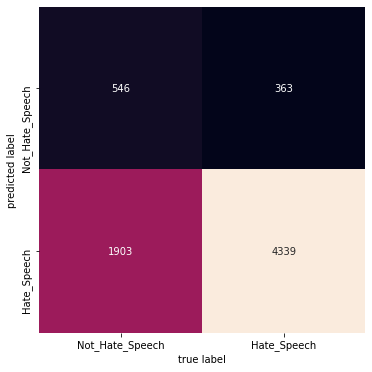

In [42]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test, svm_predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [43]:
TP = mat[1,1] # true positive 
TN = mat[0,0] # true negatives
FP = mat[0,1] # false positives
FN = mat[1,0] # false negatives

In [44]:
Specificity = TN/(TN+FP)
Sensitivity = TP/(TP+FN)
TPR=TP/(TP+FN)
FPR=FP/(FP+TN)
roc_auc_score4=roc_auc_score(y_test, svm_predictions)

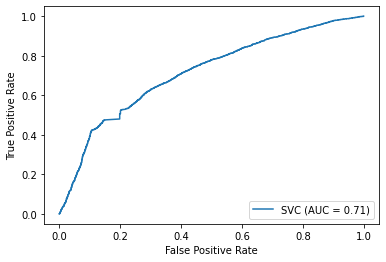

In [45]:
metrics.plot_roc_curve(svm_classifier, X_test, y_test)
plt.show()

In [46]:
precision = precision_score(y_test, svm_predictions)
recall = recall_score(y_test, svm_predictions)
acc_score = accuracy_score(y_test, svm_predictions)
score = f1_score(y_test, svm_predictions)
print('Support Vector Machines')

print('Precision: {:.4}'.format(precision))
print('Recall: {:.4}'.format(recall))

print("Accuracy: {:.4}".format(acc_score))
print("F1 Score: {:.4}".format(score))
print("Sensitivity: {:.4}".format(Sensitivity))
print("Specificity: {:.4}".format(Specificity))
print("TPR: {:.4}".format(TPR))
print("FPR: {:.4}".format(FPR))
print("roc_auc_score: {:.4}".format(roc_auc_score4))

Support Vector Machines
Precision: 0.6951
Recall: 0.9228
Accuracy: 0.6831
F1 Score: 0.7929
Sensitivity: 0.9228
Specificity: 0.2229
TPR: 0.9228
FPR: 0.7771
roc_auc_score: 0.5729


# LSTM

In [47]:
max_features=20000
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [48]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [50]:
batch_size = 36
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=1,
          validation_data=[X_test, y_test])

795/795 [==============================] - 114s 137ms/step - loss: 0.2706 - accuracy: 0.8806 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [51]:
predictions=model.predict(X_test)

In [52]:
predictions

array([[0.99562895],
       [0.9905088 ],
       [0.04423383],
       ...,
       [0.9997609 ],
       [0.98715204],
       [0.9972531 ]], dtype=float32)

In [53]:
predictions = np.round(predictions)
predictions

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

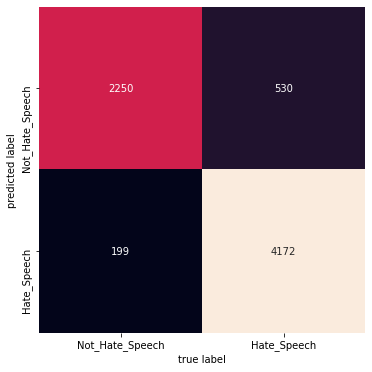

In [54]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [55]:
TP = mat[1,1] # true positive 
TN = mat[0,0] # true negatives
FP = mat[0,1] # false positives
FN = mat[1,0] # false negatives

In [56]:
Specificity = TN/(TN+FP)
Sensitivity = TP/(TP+FN)

In [57]:
TPR=TP/(TP+FN)
FPR=FP/(FP+TN)

In [58]:
roc_auc_score5=roc_auc_score(y_test, predictions)

In [59]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
acc_score = accuracy_score(y_test, predictions)
score = f1_score(y_test, predictions)
print('LSTM')

print('Precision: {:.4}'.format(precision))
print('Recall: {:.4}'.format(recall))

print("Accuracy: {:.4}".format(acc_score))
print("F1 Score: {:.4}".format(score))
print("Sensitivity: {:.4}".format(Sensitivity))
print("Specificity: {:.4}".format(Specificity))
print("TPR: {:.4}".format(TPR))
print("FPR: {:.4}".format(FPR))
print("roc_auc_score: {:.4}".format(roc_auc_score5))

LSTM
Precision: 0.9545
Recall: 0.8873
Accuracy: 0.8981
F1 Score: 0.9197
Sensitivity: 0.8873
Specificity: 0.9187
TPR: 0.8873
FPR: 0.08126
roc_auc_score: 0.903


# Bi-Directional LSTM

In [60]:
max_features = 20000
batch_size = 32
maxlen=100

In [61]:
model1 = Sequential()
model1.add(Embedding(max_features, 128, input_length=maxlen))
model1.add(Bidirectional(LSTM(64)))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

In [62]:
model1.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [63]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,658,945
Trainable params: 2,658,945
Non-trainable params: 0
_________________________________________________________________


In [64]:
model1.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=1,
          validation_data=[X_test, y_test])

894/894 [==============================] - 18s 14ms/step - loss: 0.2741 - accuracy: 0.8799 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [65]:
predictions1=model1.predict(X_test)
predictions1

array([[0.9911556 ],
       [0.99734336],
       [0.04536275],
       ...,
       [0.9997255 ],
       [0.97985935],
       [0.9988932 ]], dtype=float32)

In [66]:
predictions1 = np.round(predictions1)
predictions1

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

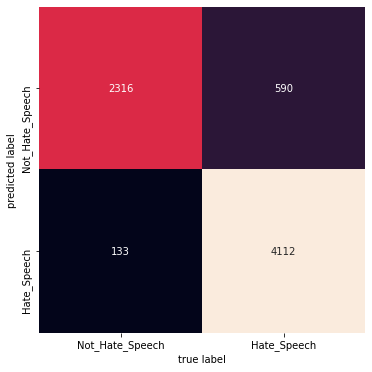

In [67]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test, predictions1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [68]:
TP = mat[1,1] # true positive 
TN = mat[0,0] # true negatives
FP = mat[0,1] # false positives
FN = mat[1,0] # false negatives

In [69]:
Specificity = TN/(TN+FP)
Sensitivity = TP/(TP+FN)
TPR=TP/(TP+FN)
FPR=FP/(FP+TN)

In [70]:
roc_auc_score6=roc_auc_score(y_test, predictions1)

In [71]:
precision = precision_score(y_test, predictions1)
recall = recall_score(y_test, predictions1)
acc_score = accuracy_score(y_test, predictions1)
score = f1_score(y_test, predictions1)
print('Bi-Directional LSTM')

print('Precision: {:.4}'.format(precision))
print('Recall: {:.4}'.format(recall))

print("Accuracy: {:.4}".format(acc_score))
print("F1 Score: {:.4}".format(score))
print("Sensitivity: {:.4}".format(Sensitivity))
print("Specificity: {:.4}".format(Specificity))
print("TPR: {:.4}".format(TPR))
print("FPR: {:.4}".format(FPR))
print("roc_auc_score: {:.4}".format(roc_auc_score6))

Bi-Directional LSTM
Precision: 0.9687
Recall: 0.8745
Accuracy: 0.8989
F1 Score: 0.9192
Sensitivity: 0.8745
Specificity: 0.9457
TPR: 0.8745
FPR: 0.05431
roc_auc_score: 0.9101


# GRU(Gated Recurrent Unit) Network

In [72]:
num_words = 30000
maxlen = 300

In [73]:
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

In [74]:
def gru_model():
    model2 = Sequential()
    model2.add(GRU(50, input_shape = (300,1), return_sequences = True))
    model2.add(GRU(1, return_sequences = False))
    model2.add(Activation('sigmoid'))
    
    model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model2
    
model2 = gru_model()

model2.fit(X_train, y_train, batch_size = 32, epochs = 1)

894/894 [==============================] - 13s 11ms/step - loss: 0.5217 - accuracy: 0.7785


In [75]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 300, 50)           7950      
_________________________________________________________________
gru_1 (GRU)                  (None, 1)                 159       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 8,109
Trainable params: 8,109
Non-trainable params: 0
_________________________________________________________________


In [76]:
predictions2=model2.predict(X_test)
predictions2

array([[0.7309568 ],
       [0.7282295 ],
       [0.313452  ],
       ...,
       [0.73105305],
       [0.72198117],
       [0.73098284]], dtype=float32)

In [77]:
predictions2 = np.round(predictions2)
predictions2

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

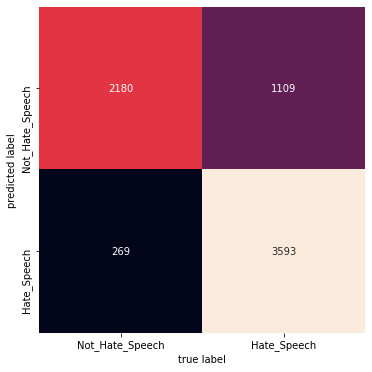

In [78]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test, predictions2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [79]:
TP = mat[1,1] # true positive 
TN = mat[0,0] # true negatives
FP = mat[0,1] # false positives
FN = mat[1,0] # false negatives

In [80]:
Specificity = TN/(TN+FP)
Sensitivity = TP/(TP+FN)
TPR=TP/(TP+FN)
FPR=FP/(FP+TN)

In [81]:
roc_auc_score7=roc_auc_score(y_test, predictions2)

In [82]:
precision = precision_score(y_test, predictions2)
recall = recall_score(y_test, predictions2)
acc_score = accuracy_score(y_test, predictions2)
score = f1_score(y_test, predictions2)
print('GRU(Gated Recurrent Unit) Network')

print('Precision: {:.4}'.format(precision))
print('Recall: {:.4}'.format(recall))

print("Accuracy: {:.4}".format(acc_score))
print("F1 Score: {:.4}".format(score))
print("Sensitivity: {:.4}".format(Sensitivity))
print("Specificity: {:.4}".format(Specificity))
print("TPR: {:.4}".format(TPR))
print("FPR: {:.4}".format(FPR))
print("roc_auc_score: {:.4}".format(roc_auc_score7))

GRU(Gated Recurrent Unit) Network
Precision: 0.9303
Recall: 0.7641
Accuracy: 0.8073
F1 Score: 0.8391
Sensitivity: 0.7641
Specificity: 0.8902
TPR: 0.7641
FPR: 0.1098
roc_auc_score: 0.8272


In [83]:
df2=df

In [84]:
df2.head()

,text,target
0,drasko said impressed girls cooked half chicke...,1
1,drasko cook half bird idiot,1
2,hopefully cooks drasko ep,1
3,course born serbia fucked serbian film,1
4,girls equivalent irritating asian girls couple...,1


In [85]:
X=list(df2['text'])
y=df2['target'].values.tolist()

In [86]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# BERT

In [87]:
from transformers import BertTokenizer, TFBertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [88]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [89]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [90]:
model3 = TFBertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model3.compile(optimizer=optimizer, loss=model3.compute_loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
history=model3.fit(train_dataset.shuffle(1000).batch(16), epochs=1, batch_size=16, validation_data=test_dataset.shuffle(1000).batch(16))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [92]:
test_dataset1 = test_dataset.batch(16)

In [93]:
predictions3=model3.predict(test_dataset1)

In [94]:
predictions3=predictions3.logits
predictions3

array([[ 0.19755575, -0.55869454],
       [-1.2507448 ,  0.75305027],
       [-2.3021367 ,  2.4176786 ],
       ...,
       [-0.14336246, -0.25499764],
       [ 0.8467277 , -0.8110126 ],
       [-2.2953708 ,  2.4130228 ]], dtype=float32)

In [95]:
predictions3 = tf.math.argmax(predictions3, axis=1)
predictions3

<tf.Tensor: shape=(7151,), dtype=int64, numpy=array([0, 1, 1, ..., 0, 0, 1])>

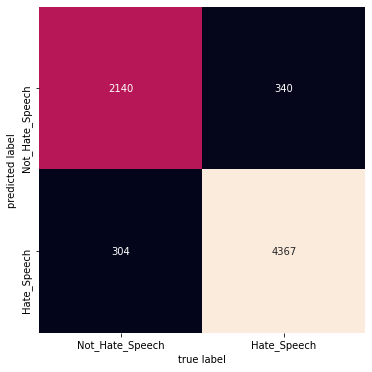

In [96]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test, predictions3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [97]:
TP = mat[1,1] # true positive 
TN = mat[0,0] # true negatives
FP = mat[0,1] # false positives
FN = mat[1,0] # false negatives

In [98]:
Specificity = TN/(TN+FP)
Sensitivity = TP/(TP+FN)
TPR=TP/(TP+FN)
FPR=FP/(FP+TN)
roc_auc_score8=roc_auc_score(y_test, predictions3)

In [99]:
history.history

{'accuracy': [0.8957065939903259],
 'loss': [0.2519451379776001],
 'val_accuracy': [0.9099426865577698],
 'val_loss': [0.21339933574199677]}

In [100]:
precision = precision_score(y_test, predictions3)
recall = recall_score(y_test, predictions3)
acc_score = accuracy_score(y_test, predictions3)
score = f1_score(y_test, predictions3)
print('BERT')

print('Precision: {:.4}'.format(precision))
print('Recall: {:.4}'.format(recall))

print("Accuracy: {:.4}".format(acc_score))
print("F1 Score: {:.4}".format(score))
print("Sensitivity: {:.4}".format(Sensitivity))
print("Specificity: {:.4}".format(Specificity))
print("TPR: {:.4}".format(TPR))
print("FPR: {:.4}".format(FPR))
print("roc_auc_score: {:.4}".format(roc_auc_score8))

BERT
Precision: 0.9349
Recall: 0.9278
Accuracy: 0.9099
F1 Score: 0.9313
Sensitivity: 0.9278
Specificity: 0.8756
TPR: 0.9278
FPR: 0.1244
roc_auc_score: 0.9017


# DistilBert

In [101]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

In [102]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [103]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [104]:
model4 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model4.compile(optimizer=optimizer, loss=model4.compute_loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_58', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [105]:
history=model4.fit(train_dataset.shuffle(1000).batch(16), epochs=1, batch_size=16, validation_data=test_dataset.shuffle(1000).batch(16))

1788/1788 [==============================] - 403s 219ms/step - loss: 0.2377 - accuracy: 0.8999 - val_loss: 0.1941 - val_accuracy: 0.9175


In [106]:
test_dataset2 = test_dataset.batch(16)

In [107]:
predictions4=model4.predict(test_dataset2)

In [108]:
predictions4=predictions4.logits
predictions4.shape

(7151, 2)

In [109]:
predictions4= tf.math.argmax(predictions4, axis=1)
predictions4

<tf.Tensor: shape=(7151,), dtype=int64, numpy=array([0, 1, 1, ..., 1, 0, 1])>

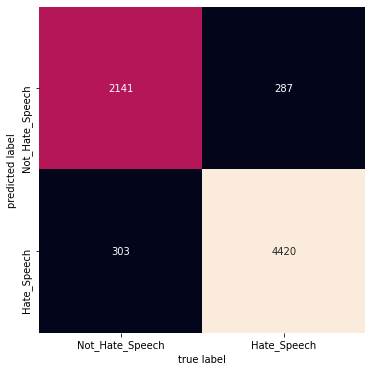

In [110]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test, predictions4)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [111]:
TP = mat[1,1] # true positive 
TN = mat[0,0] # true negatives
FP = mat[0,1] # false positives
FN = mat[1,0] # false negatives

In [112]:
Specificity = TN/(TN+FP)
Sensitivity = TP/(TP+FN)
TPR=TP/(TP+FN)
FPR=FP/(FP+TN)
roc_auc_score9=roc_auc_score(y_test, predictions4)

In [113]:
history.history

{'accuracy': [0.8998671174049377],
 'loss': [0.23766279220581055],
 'val_accuracy': [0.9174940586090088],
 'val_loss': [0.1940980851650238]}

In [114]:
precision = precision_score(y_test, predictions4)
recall = recall_score(y_test, predictions4)
acc_score = accuracy_score(y_test, predictions4)
score = f1_score(y_test, predictions4)
print('DistilBert')

print('Precision: {:.4}'.format(precision))
print('Recall: {:.4}'.format(recall))

print("Accuracy: {:.4}".format(acc_score))
print("F1 Score: {:.4}".format(score))
print("Sensitivity: {:.4}".format(Sensitivity))
print("Specificity: {:.4}".format(Specificity))
print("TPR: {:.4}".format(TPR))
print("FPR: {:.4}".format(FPR))
print("roc_auc_score: {:.4}".format(roc_auc_score9))

DistilBert
Precision: 0.9358
Recall: 0.939
Accuracy: 0.9175
F1 Score: 0.9374
Sensitivity: 0.939
Specificity: 0.876
TPR: 0.939
FPR: 0.124
roc_auc_score: 0.9075


# Electra

In [115]:
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [116]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [117]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [118]:
model5 = TFElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model5.compile(optimizer=optimizer, loss=model5.compute_loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/54.5M [00:00<?, ?B/s]

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [119]:
history=model5.fit(train_dataset.shuffle(1000).batch(16), epochs=1, batch_size=16, validation_data=test_dataset.shuffle(1000).batch(16))

1788/1788 [==============================] - 276s 143ms/step - loss: 0.2749 - accuracy: 0.8801 - val_loss: 0.2234 - val_accuracy: 0.9050


In [120]:
test_dataset3 = test_dataset.batch(16)

In [121]:
predictions5=model5.predict(test_dataset3)

In [122]:
predictions5=predictions5.logits
predictions5.shape

(7151, 2)

In [123]:
predictions5 = tf.math.argmax(predictions5, axis=1)
predictions5

<tf.Tensor: shape=(7151,), dtype=int64, numpy=array([0, 1, 1, ..., 0, 0, 1])>

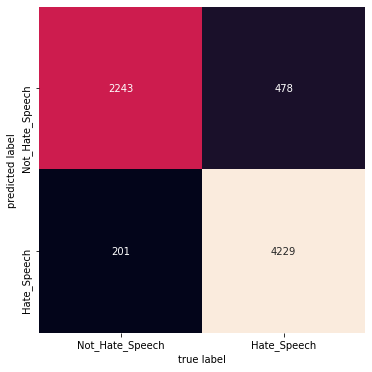

In [124]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test, predictions5)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [125]:
TP = mat[1,1] # true positive 
TN = mat[0,0] # true negatives
FP = mat[0,1] # false positives
FN = mat[1,0] # false negatives

In [126]:
Specificity = TN/(TN+FP)
Sensitivity = TP/(TP+FN)
TPR=TP/(TP+FN)
FPR=FP/(FP+TN)
roc_auc_score10=roc_auc_score(y_test, predictions5)

In [127]:
history.history

{'accuracy': [0.8801133036613464],
 'loss': [0.2749262750148773],
 'val_accuracy': [0.9050482511520386],
 'val_loss': [0.22340501844882965]}

In [128]:
precision = precision_score(y_test, predictions5)
recall = recall_score(y_test, predictions5)
acc_score = accuracy_score(y_test, predictions5)
score = f1_score(y_test, predictions5)
print('Electra')

print('Precision: {:.4}'.format(precision))
print('Recall: {:.4}'.format(recall))

print("Accuracy: {:.4}".format(acc_score))
print("F1 Score: {:.4}".format(score))
print("Sensitivity: {:.4}".format(Sensitivity))
print("Specificity: {:.4}".format(Specificity))
print("TPR: {:.4}".format(TPR))
print("FPR: {:.4}".format(FPR))
print("roc_auc_score: {:.4}".format(roc_auc_score10))

Electra
Precision: 0.9546
Recall: 0.8984
Accuracy: 0.905
F1 Score: 0.9257
Sensitivity: 0.8984
Specificity: 0.9178
TPR: 0.8984
FPR: 0.08224
roc_auc_score: 0.9081


# Roberta

In [129]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

In [130]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [131]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [132]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [133]:
model7 = TFRobertaForSequenceClassification.from_pretrained('roberta-base')
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model7.compile(optimizer=optimizer, loss=model7.compute_loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [134]:
history=model7.fit(train_dataset.shuffle(1000).batch(16), epochs=1, batch_size=16, validation_data=test_dataset.shuffle(1000).batch(16))

1788/1788 [==============================] - 868s 474ms/step - loss: 0.2675 - accuracy: 0.8871 - val_loss: 0.2370 - val_accuracy: 0.9055


In [135]:
test_dataset5 = test_dataset.batch(16)

In [136]:
predictions7=model7.predict(test_dataset5)

In [137]:
predictions7=predictions7.logits
predictions7.shape

(7151, 2)

In [138]:
predictions7 = tf.math.argmax(predictions7, axis=1)
predictions7

<tf.Tensor: shape=(7151,), dtype=int64, numpy=array([0, 1, 1, ..., 0, 0, 1])>

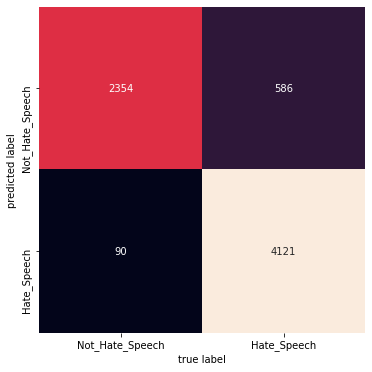

In [139]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test, predictions7)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [140]:
TP = mat[1,1] # true positive 
TN = mat[0,0] # true negatives
FP = mat[0,1] # false positives
FN = mat[1,0] # false negatives

In [141]:
Specificity = TN/(TN+FP)
Sensitivity = TP/(TP+FN)
TPR=TP/(TP+FN)
FPR=FP/(FP+TN)
roc_auc_score12=roc_auc_score(y_test, predictions7)

In [142]:
history.history

{'accuracy': [0.8871058225631714],
 'loss': [0.2675054371356964],
 'val_accuracy': [0.9054677486419678],
 'val_loss': [0.23699070513248444]}

In [143]:
precision = precision_score(y_test, predictions7)
recall = recall_score(y_test, predictions7)
acc_score = accuracy_score(y_test, predictions7)
score = f1_score(y_test, predictions7)
print('Roberta')

print('Precision: {:.4}'.format(precision))
print('Recall: {:.4}'.format(recall))

print("Accuracy: {:.4}".format(acc_score))
print("F1 Score: {:.4}".format(score))
print("Sensitivity: {:.4}".format(Sensitivity))
print("Specificity: {:.4}".format(Specificity))
print("TPR: {:.4}".format(TPR))
print("FPR: {:.4}".format(FPR))
print("roc_auc_score: {:.4}".format(roc_auc_score12))

Roberta
Precision: 0.9786
Recall: 0.8755
Accuracy: 0.9055
F1 Score: 0.9242
Sensitivity: 0.8755
Specificity: 0.9632
TPR: 0.8755
FPR: 0.03682
roc_auc_score: 0.9193
